In [1]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
from chromax import Simulator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import os
os.environ["KERAS_BACKEND"] = "jax"
import matplotlib
from jax import device_get


In [2]:

def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr


def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df


In [3]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [4]:
%R -o x

In [5]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [6]:
# %R install.packages("AlphaSimR")

In [7]:
%%R
library("AlphaSimR")

Loading required package: R6


In [8]:
%%R
nInd = 10
nChr = 2
segSites = 5

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [9]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [10]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [11]:
nMarkers = segSites * nChr

In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape


import random

import random

def simplify_geneticmap(lst, qtl):
    # Select 'qtl' random indexes
    indexes_positive = random.sample(range(len(lst)), qtl)
    
    # Select 'qtl' random indexes not already selected
    remaining_indexes = set(range(len(lst))) - set(indexes_positive)
    indexes_negative = random.sample(remaining_indexes, qtl)

    # Modify the list
    for i in range(len(lst)):
        if i in indexes_positive:
            lst[i] = random.uniform(0.5, 1.0)  # Assign random float between 0.5 and 1.0
        elif i in indexes_negative:
            lst[i] = random.uniform(-0.5, -1.0)  # Assign random float between -0.5 and -1.0
        else:
            lst[i] = 0  # Assign 0

    return lst

2024-01-07 12:48:03.312853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
def plot_population_heatmap(ax, population_data, marker_strength):
    summed_data = np.sum(population_data, axis=2)
    cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"])
    strength_cmap = matplotlib.colormaps.get_cmap('RdYlGn')  # Updated line
    sns.heatmap(summed_data, cmap=cmap, cbar_kws={'ticks': [0, 1, 2]}, ax=ax)

    ax.set_xticks(np.arange(population_data.shape[1]) + 0.5)
    marker_labels = [f'{i+1}' for i in range(population_data.shape[1])]
    ax.set_xticklabels(marker_labels, rotation=0, ha='center')

    for tick_label, strength in zip(ax.get_xticklabels(), marker_strength):
        tick_label.set_backgroundcolor(strength_cmap((strength + 1) / 2))  # Normalize and map the strength value
        tick_label.set_color('white')
        tick_label.set_fontweight('bold')
        tick_label.set_bbox(dict(facecolor=strength_cmap((strength + 1) / 2), edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_title("Heatmap of Population Genotype Dosages")
    ax.set_xlabel("Markers")
    ax.set_ylabel("Individuals")

def plot_allele_frequencies(ax, data, marker_strength, sort_by_allele_0=False, bar_width=0.8):
    allele_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=3), axis=2, arr=data)
    total_allele_counts = allele_counts.sum(axis=0)
    allele_frequencies = total_allele_counts / total_allele_counts.sum(axis=1)[:, np.newaxis]

    allele_0_proportions = allele_frequencies[:, 0]
    allele_1_proportions = allele_frequencies[:, 1]
    x_positions = np.arange(1, len(allele_0_proportions) + 1)
    normalized_strength = (np.array(marker_strength) + 1) / 2

    cmap = plt.cm.RdYlGn

    if sort_by_allele_0:
        sorted_indices = np.argsort(-allele_0_proportions)
        allele_0_proportions = allele_0_proportions[sorted_indices]
        allele_1_proportions = allele_1_proportions[sorted_indices]
        normalized_strength = normalized_strength[sorted_indices]

    for xpos, a0, a1, strength in zip(x_positions, allele_0_proportions, allele_1_proportions, normalized_strength):
        ax.bar(xpos, a0, color='red', edgecolor='black', width=bar_width, label='Allele 0' if xpos == 1 else "")
        ax.bar(xpos, a1, bottom=a0, color='black', edgecolor='black', width=bar_width, label='Allele 1' if xpos == 1 else "")
        ax.text(xpos, -0.05, f'{xpos}', horizontalalignment='center', verticalalignment='center', 
                 color='white', fontsize=8, fontweight='bold', 
                 bbox=dict(facecolor=cmap(strength), edgecolor='none', boxstyle='round,pad=0.2'))

    ax.set_ylim(-0.15, 1)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Marker Position')
    ax.set_title('Proportion of Alleles 0 and 1 at Each Marker' + (' (Sorted by Allele 0)' if sort_by_allele_0 else ''))
    ax.legend(loc='upper right')

import tempfile
import os

def create_frame(farm, episode):
    temp_dir = farm.temp_dir
    fig = plt.figure(figsize=(10, 15))  # Adjust the figure size

    gs = gridspec.GridSpec(3, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0])
    farm.view_policy(ax1, episode)

    ax2 = fig.add_subplot(gs[1])
    plot_population_heatmap(ax2, self.current_population, self.marker_strength)

    ax3 = fig.add_subplot(gs[2])
    plot_allele_frequencies(ax3, self.current_population, self.marker_strength)

    # Save the figure as a png in the temporary directory
    filename = os.path.join(temp_dir.name, f'frame_{episode}.png')
    plt.savefig(filename)
    plt.close(fig)  # Close the plot

    return filename  # Return the filename for future use



In [14]:
#VISUALIZATIONS



#average fitness for each episode
import matplotlib.pyplot as plt
import pandas as pd





def plot_initial_population_policy_tracker_updated(dataset, indices, true_values, ax=None):
    def top_50_percent_indices(array):
        """Helper function to find the top 50% indices of an array."""
        threshold = np.percentile(array, 50)
        return np.where(array > threshold)

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure and axes if none is provided

    # Preparing the data for imshow - adding the 'true_values' as the first column
    data_for_plotting = np.column_stack([true_values.squeeze()] + [d.squeeze() for d in dataset])

    # Displaying the arrays as columns with appropriate coloring
    ax.imshow(data_for_plotting, aspect='auto', cmap=plt.cm.viridis)

    # Adding red rectangles for top 50% values in each array, including 'true_values'
    all_data = [true_values] + dataset
    for i, array in enumerate(all_data):
        top_indices = top_50_percent_indices(array.squeeze())
        for index in top_indices[0]:
            rect = plt.Rectangle((i-0.5, index-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3)
            ax.add_patch(rect)

    # Setting the axis labels and title
    ax.set_xlabel("Episode Number")
    ax.set_ylabel("Individual ID")

    # Setting x-axis tick labels to include 'Truth' for the first column and sampled indices for the rest
    tick_labels = ['Truncation'] + [f"{idx+1}" for idx in indices]
    plt.xticks(range(len(all_data)), tick_labels)

    plt.yticks(range(len(true_values.squeeze())), range(len(true_values.squeeze())))

    # Adding grid lines
    ax.grid(True, which='both', axis='both', linestyle='-', color='lightgrey', linewidth=0.5)

    ax.set_title("Initial Population Policy Tracker")
    
    return ax




def sample_dataset_by_percentile(dataset, percentile):
    """
    Samples a dataset based on a given percentile and returns the sampled data along with their original indices.

    :param dataset: List or array-like structure containing the dataset.
    :param percentile: The percentile step to use for sampling (e.g., 10 for 10th percentile steps).

    :return: A tuple containing two lists - the sampled dataset and their corresponding indices.
    """
    if not 0 < percentile <= 100:
        raise ValueError("Percentile must be between 0 and 100")

    num_elements = len(dataset)
    step = int(num_elements * (percentile / 100))
    
    # Handle the case where step size is 0 due to a very small dataset
    if step == 0:
        step = 1

    # Sampling indices
    sampled_indices = range(0, num_elements, step)

    # Sampling the dataset
    sampled_dataset = [dataset[i] for i in sampled_indices]

    return sampled_dataset, list(sampled_indices)

def baseline_plot(ax=None):
    total_cycles = farm.total_cycles
    trunk_farm = farm
    for i in range(total_cycles):
        truncate_cycle(trunk_farm)

    data = [x.to_numpy().flatten() for x in trunk_farm.history]
    df = pd.DataFrame(data).T

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure and axes if none is provided

    sns.boxplot(data=df, ax=ax)

    ax.set_title('Baseline Heuristic')  # Add title
    ax.set_xlabel('Episode Number')  # Add x-axis label

    return ax






# Example usage:
# sampled_data, sampled_indices  = sample_dataset_by_percentile(farm.fitness_history, 10)
# plot_initial_population_policy_tracker_updated(sampled_data, sampled_indices, farm.simulator.GEBV(farm.initial_population) )

# baseline_plot()

# fitness_plot()

import psutil
import os

# Function to convert large number of bytes into a human readable format
def bytes_to_human(n):
    symbols = ('K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y')
    prefix = {}
    for i, s in enumerate(symbols):
        prefix[s] = 1 << (i + 1) * 10
    for s in reversed(symbols):
        if n >= prefix[s]:
            value = float(n) / prefix[s]
            return '%.1f%s' % (value, s)
    return "%sB" % n

# Function to print out memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {bytes_to_human(process.memory_info().rss)}")
    return float(bytes_to_human(process.memory_info().rss)[:-1])

# Print out memory usage at the start
print_memory_usage()

# Your code here...
# ...

# Print out memory usage at the end
print_memory_usage()





# policy = actor_output
# current_population = population_dummy
# simulator = simulator
# newpop, reward  = policy2offspring_reward(policy, current_population, simulator)





from scipy.ndimage.filters import gaussian_filter1d

import pandas as pd                                                

def fitness_plot(farm_history, farm_cycles, ax=None):
    farm_history = np.array(farm_history)
    chunk_size = farm_cycles
    data_list = farm_history
    chunked_list = [data_list[i:i + chunk_size] for i in range(0, len(data_list), chunk_size)]
    palette = sns.color_palette("husl", chunk_size)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5)) 

    for i in range(data_list.shape[1]):  # iterate over columns
        cycle = data_list[:, i]  # get the i-th cycle
        cycle_df = pd.DataFrame(cycle)
        window_size = int(len(cycle_df) * 0.1)  # 10% of the array length
        cycle_smooth = cycle_df.rolling(window_size).mean()  # Apply rolling average
        ax.plot(cycle_smooth, color=palette[i], label=f'cycle {i+1}')  

    for i, baseline in enumerate(farm.baselines):
        ax.axhline(y=baseline, color='g', linestyle='--', label=f'Heuristic Baseline {i}')  
        ax.annotate(f'Heuristic Baseline {i}', (0, baseline), textcoords="offset points", xytext=(10,10), ha='center')  

    ax.axhline(y=farm.random_baseline, color='r', linestyle='--', label='Random Action Baseline')  
    ax.annotate(f'Random Action Baseline', (0, farm.random_baseline), textcoords="offset points", xytext=(10,10), ha='center')  

    ax.legend()

    return ax


Memory usage: 635.4M
Memory usage: 635.4M


/tmp/ipykernel_1797300/1764213802.py:159: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [15]:
import numpy as np
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam



#dummy functions to  generate fake data to develop the training pipeline
def pop_gen(b, n, m, d):
    return np.random.randint(2, size=(b, n, m, d))
def reward_gen():
    return np.random.rand
def scores_gen(n):
    return np.random.rand(1, n)

import numpy as np
from scipy import stats
def get_r(values):

    # Create an array of indices, same length as your list
    indices = np.array(range(len(values)))

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(indices, values)
    return slope

# genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
# genetic_map['Yield'] = simplify_geneticmap(list(genetic_map['Yield']),4)

# n = int(nInd[0])
# m = int(nMarkers)
# d = 2
# total_parents = n*2

# population_dummy = pop_gen(1, n, m, d)  # Extra dimension for batch size
# scores_dummy =  scores_gen(n) # Extra dimension for batch size

# actor_model = create_actor(n,m,d,total_parents, population_dummy, scores_dummy)
# actor_output = actor_model([population_dummy, scores_dummy])
# critic_model = create_critic(n,m,d, population_dummy, scores_dummy,actor_output)

# simulator = Simulator(genetic_map=genetic_map, h2=.5)
# simulator.load_population('mypop.npy')
# initial_scores = simulator.GEBV(population_dummy[0])

# TOTAL_EPISODES=3
# before = print_memory_usage()
# for episodes in range(TOTAL_EPISODES):
#     inputs = tf.random.normal([1, n, m, d]) # replace with actual inputs
#     scores_dummy = tf.random.normal([1, n]) # replace with actual scores
#     #policy, current_population, simulator
#     new_pop,reward = policy2offspring_reward(actor_output, population_dummy, simulator)
#     train_step(actor_model, critic_model, inputs, scores_dummy, reward)
#     tf.keras.backend.clear_session()
# after = print_memory_usage()

# print(f'cost per episode: {( after - before ) / TOTAL_EPISODES}')

In [16]:
from statistics import mean

def split_and_average(lst, set_size):
    # lst is from get_baseline
    #average list
    lst = [x.mean() for x in lst]
    # Split the list into sublists
    split_lst = [lst[i:i + set_size] for i in range(0, len(lst), set_size)]

    # Calculate the average of the x-th element in each sublist
    averages = []
    for x in range(set_size):
        x_elements = [sublist[x] for sublist in split_lst if len(sublist) > x]
        averages.append(mean(x_elements))

    return averages

In [17]:
# def select_parents(policy):
#     """
#         input: Policy from actor ( metric value for each individual )
#         returns : index of parents to be included in random_crosses for next step of breeding program
#     """
#     # Calculate the number of top elements to select.
#     k = policy.shape[1] // 2
#     # If the tensor has an odd number of elements, add one to 'k' to get the upper half.
#     if policy.shape[1] % 2 != 0:
#         k += 1
#     values, indices = tf.math.top_k(policy, k)
#     return values,indices

# def create_actor(n, m, d, layer_size,learning_rate):
#     """
#         input:
#         n : population size
#         m : total markers
#         d : ploidy
        
#         output:
#         selection metrics for breeder agent to act on
        
#     """
#     score_input = tf.keras.layers.Input(shape=(n,))
#     actor_input = tf.keras.layers.Input(shape=(n, m, d))

#     x1 = Flatten()(actor_input)
#     x2 = Dense(layer_size, activation='relu')(score_input)  # Dense layer for the scores
#     x = tf.keras.layers.Concatenate()([x1, x2])  # Concatenate the flattened actor input and the score input
#     x = Dense(layer_size, activation='relu')(x)
#     x = Dense(layer_size, activation='relu')(x)
#     x = Dense(n, activation='linear')(x)  # Output layer with n linear units
#     optimizer = Adam(learning_rate=learning_rate)

#     actor_model = tf.keras.models.Model([actor_input, score_input], x)
#     actor_model.compile(optimizer=optimizer, loss='mean_squared_error')  # Use MSE loss for value prediction

#     return actor_model

# def create_critic(n, m, d, layer_size,learning_rate):
#     """
#         input:
#         n : population size
#         m : total markers
#         d : ploidy

#         output:
#         scalar predicted reward (given)
        
#     """
#     score_input = tf.keras.layers.Input(shape=(n,))
#     actor_output_input = tf.keras.layers.Input(shape=(n,))
#     critic_input = tf.keras.layers.Input(shape=(n, m, d))

#     x1 = Flatten()(critic_input)
#     x2 = Dense(layer_size, activation='relu')(score_input)  # Dense layer for the scores
#     x3 = Flatten()(actor_output_input)  # Flatten the actor's output
#     x = tf.keras.layers.Concatenate()([x1, x2, x3])  # Concatenate the flattened critic input, score input, and actor's output
#     x = Dense(layer_size, activation='relu')(x)
#     x = Dense(layer_size, activation='relu')(x)
#     x = Dense(1, activation='linear')(x)  # Output layer with single linear unit
#     optimizer = Adam(learning_rate=learning_rate)
#     critic_model = tf.keras.models.Model([critic_input, score_input, actor_output_input], x)
#     critic_model.compile(optimizer=optimizer, loss='mean_squared_error')  # Use MSE loss for value prediction

#     return critic_model






# class BreedingProgram:
#     """
#     Represents a breeding program with a PPO agent. Actor-Critic
#     """

#     def __init__(self, cook_base, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability, learning_rate =.001, layer_size=8, episodes = 50, cycles=2):
#         """
#         Initializes the breeding program.
#         """

#         # Initialize the basic attributes
#         self.cook_base = cook_base
#         self.population_size = population_size
#         self.marker_count = marker_count
#         self.initial_population = initial_population
#         self.genetic_map = genetic_map
#         self.max_generation = max_generation
#         self.marker_strength = np.array(self.genetic_map['Yield'])
#         self.episodes = episodes
#         self.cycles = cycles
#         self.learning_rate = learning_rate
#         self.layer_size = layer_size

#         # Initialize the simulator
#         self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
#         self.simulator.load_population('mypop.npy')
#         self.initial_scores = self.simulator.GEBV(self.initial_population)

#         #tempdir - future for capturing gifs
#         self.temp_dir = tempfile.TemporaryDirectory()

#         # Initialize the current generation and history
#         self.current_generation = 0
#         self.history = []

#         # Initialize the Actor and Critic models
#         self.actor = create_actor(n=self.population_size,
#                                   m=self.marker_count,
#                                   d=2,
#                                   layer_size=self.layer_size,
#                                   learning_rate = self.learning_rate,
#                                   )
#         population_dummy = np.random.rand(1, self.population_size,self.marker_count,2)  # Extra dimension for batch size
#         scores_dummy = np.random.rand(1, self.population_size)  # Extra dimension for batch size
#         output_dummy = self.actor([population_dummy, scores_dummy])

#         self.critic = create_critic(n=self.population_size,
#                                   m=self.marker_count,
#                                   d=2,
#                                                                     layer_size=self.layer_size,
#                                   learning_rate = self.learning_rate,

#         )
        


#         self.critic_history = []
#         self.actor_history = []
#         self.reward_history = []
#         self.fitness_history = []
#         self.policy_history = []

#         self.true_history = [] # stores the mean reward for a given mass selection round

#                 # Start the breeding program
#         self._start_breeding_program()
        
#     def _start_breeding_program(self):
#         """
#         Starts the breeding program.
#         """
#         self.current_population = self.initial_population
#         self.current_scores = self.simulator.GEBV(self.initial_population)
#         self.history.append(self.current_scores)
#         self.agent_history = []
#         if self.cook_base:
#             self.get_baselines()
#             self.snapshot_history = []
#             self.snapshot_history.append(self.actor([self.initial_population.reshape(1, *self.initial_population.shape), self.initial_scores.to_numpy().transpose()], training=True).numpy())
#             self.random_baseline = self.get_random_baseline()
#     # USE AGENT
        

    
#     def agent_select(self,population):
#         """
#         used to test the existing agent given a population (n,m,d)
#         """
#         # Prepare inputs for actor model
#         current_pop = device_get(population.reshape(1, *population.shape))
#         current_scores = self.simulator.phenotype(current_pop[0])
#         current_scores = current_scores.to_numpy().transpose()

#         # Get policy and select parents
#         policy = self.actor([current_pop, current_scores])

#         return policy

#     def truncate_cycle(self):
#         #TODO ADD N_CROSSES to sample multiple times from same parent combos -> get average reward IMPORTANT?!
#         selected_parents = self.simulator.select(self.current_population, k = (self.current_population.shape[0] / 2))
#         new_pop = self.simulator.random_crosses(selected_parents, n_crosses=self.current_population.shape[0])
#         new_score = self.simulator.GEBV(new_pop)
#         return new_pop, new_score
    
#     def get_baseline(self, ax=None):
#         data = []
#         for _ in range(5): #5 samples for baseline target score
#             self.reset()
#             for i in range(self.cycles):
#                 new_pop, new_score = self.truncate_cycle()
#                 data.append(new_score)
#                 self.current_population = new_pop
#                 self.current_scores = new_score
#         data = [x.to_numpy().flatten() for x in data]
#         df = pd.DataFrame(data).T

#         if ax is None:
#             return None, data  # Create a new figure and axes if none is provided

#         sns.boxplot(data=df, ax=ax)

#         ax.set_title('Baseline Heuristic Replicates')  # Add title
#         ax.set_xlabel('Episode Number')  # Add x-axis label

#         return ax, data
    
#     @tf.function
#     def train_step(self, inputs, scores_dummy,reward):
#         with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
#             actor_output = self.actor([inputs, scores_dummy], training=True)
#             critic_value = self.critic([inputs, scores_dummy, actor_output], training=True)
#             actor_loss = -tf.reduce_mean(critic_value)
#             critic_loss = tf.keras.losses.huber(reward, critic_value)
        
#         actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
#         critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)

#         return (actor_grads, critic_grads), actor_loss, critic_loss
    
#     def policy2offspring_reward(self, policy, replicates=30):
#         """
#         Runs multiple replicates for a given policy to calculate the average reward.
#         """
#         avg_reward = 0
#         for _ in range(replicates):
#             parent_values, parent_indices = select_parents(policy)
#             selected_parents = self.current_population[parent_indices.numpy()]
#             # Ensure that the new population is generated for each replicate
#             new_pop = self.simulator.random_crosses(selected_parents[0], n_crosses=selected_parents[0].shape[0])
#             # Calculate the reward for the new population
#             mass_score = self.simulator.GEBV(new_pop).mean()[0]
#             reward = mass_score - self.simulator.GEBV(self.initial_population).mean()[0]
#             avg_reward += reward
#         avg_reward /= replicates
#         # Return the last new_pop, though you might want to consider how to handle multiple populations
#         new_pop = np.vstack((new_pop, self.simulator.random_crosses(selected_parents[0], n_crosses=selected_parents[0].shape[0])))

#         return new_pop, avg_reward


        
#     def run_cycle(self, replicates=30):
#         """
#         runs a cycle of selection. updates the current population/scores and does training step
#         """
#         inputs = add_batchdim(self.current_population)
#         scores_dummy = np.array(self.current_scores.transpose())
#         actor_output = self.actor([inputs, scores_dummy])
#         # Run policy2offspring_reward with multiple replicates
#         new_pop, avg_reward = self.policy2offspring_reward(actor_output, replicates)
#         # Use average reward for training
#         grads, actor_loss, critic_loss = self.train_step(inputs, scores_dummy, avg_reward)
#         # Reshape new_pop if necessary, depending on your simulator's implementation
#         # ...
#         self.critic_history.append(critic_loss.numpy()[0])
#         self.actor_history.append(actor_loss.numpy())
#         self.reward_history.append(avg_reward)
#         # Assuming mass_score is equivalent to avg_reward in this context
#         self.fitness_history.append(avg_reward)
#         self.current_population = new_pop
#         self.current_scores = self.simulator.GEBV(new_pop)
#         return avg_reward, self.current_scores, grads

#     def get_baselines(self):
#         ax, data = self.get_baseline()
#         baselines = split_and_average(data,self.cycles)
#         self.baselines = baselines
#         return baselines
    
#     def reset(self):
#         self.current_population = self.initial_population
#         self.current_scores = self.initial_scores
#         self.actor_history = []
#         self.critic_history = []
#         self.reward_history = []
#         self.fitness_history = []

#     def get_random_baseline(self):
#         peaks = []
#         new_pop = self.simulator.random_crosses(self.initial_population, n_crosses=self.initial_population.shape[0])
#         averages = []
#         prev_avg = None

#         for _ in range(30): # 30 replicates of up to 50 episodes each
#             new_pop = self.simulator.random_crosses(self.initial_population, n_crosses=self.initial_population.shape[0])
#             for _ in range(50):
#                 new_pop = self.simulator.random_crosses(new_pop, n_crosses=self.initial_population.shape[0])
#                 new_score = self.simulator.GEBV(new_pop)
#                 averages.append(new_score)
                
#                 # If we have at least 5 elements, calculate the average of the last 5
#                 if len(averages) >= 5:
#                     current_avg = np.average(averages[-5:])
                    
#                     # If the previous average is not None and is the same as the current average, break the loop
#                     if prev_avg is not None and prev_avg == current_avg:
#                         peaks.append(current_avg)
#                         break

#                     # Update the previous average
#                     prev_avg = current_avg
#         return np.array(peaks).mean()
#     def overfit(self, num_replicates=10, num_episodes=50, num_cycles=2):
#         # Initialize 3D arrays to store metrics for each replicate, episode, and cycle
#         actor_losses = np.zeros((num_replicates, num_episodes, num_cycles))
#         critic_losses = np.zeros((num_replicates, num_episodes, num_cycles))
#         rewards = np.zeros((num_replicates, num_episodes, num_cycles))

#         for replicate in range(num_replicates):
#             self.reset()  # Reset the program for each replicate

#             for episode in range(num_episodes):

#                 for cycle in range(num_cycles):
#                     # Run a single cycle of the breeding program
#                     reward, _, (actor_loss, critic_loss) = self.run_cycle()

#                     # Convert actor_loss and critic_loss to numpy arrays if they are not already

#                     actor_loss = [x.numpy() for x in actor_loss]
#                     print(actor_loss)
#                     print(len(actor_loss[0]))
#                     # # actor_loss = [x.numpy()[0] for x in actor_loss]
#                     # # critic_loss =[x.numpy()[0] for x in critic_loss]

#                     # # Ensure actor_loss and critic_loss are scalars
#                     # actor_loss_scalar = actor_loss.item() if actor_loss.shape == () else actor_loss.mean()
#                     # critic_loss_scalar = critic_loss.item() if critic_loss.shape == () else critic_loss.mean()

#                     # # Store scalar metrics in their respective arrays
#                     # actor_losses[replicate, episode, cycle] = actor_loss_scalar
#                     # critic_losses[replicate, episode, cycle] = critic_loss_scalar
#                     # rewards[replicate, episode, cycle] = reward

#         # Return a dictionary of metrics arrays
#         return {
#             'actor_loss': actor_losses,
#             'critic_loss': critic_losses,
#             'reward': rewards
#         }



# metrics = farm.overfit(num_replicates=num_replicates)



In [18]:

def sample_two_offspring_per_cross(dataset):
    """
    Samples two offspring per cross from the dataset.

    Parameters:
    dataset (np.ndarray): The input dataset with shape (n_cross, n_offspring, markers, diploid).

    Returns:
    np.ndarray: A new array with sampled offspring, shape (n_cross, 2, markers, diploid).
    """
    n_cross = dataset.shape[0]
    n_offspring_per_cross = 2
    # Create an array to store the indices of the offspring to sample
    indices = np.random.choice(dataset.shape[1], size=(n_cross, n_offspring_per_cross), replace=False)
    # Use advanced indexing to select two offspring per cross
    sampled_offspring = dataset[np.arange(n_cross)[:, None], indices, :, :]
    return sampled_offspring.reshape(-1, sampled_offspring.shape[2], sampled_offspring.shape[3])




def collapse_first_two_axes(dataset):
    """
    Collapses the first two axes of the dataset.

    Parameters:
    dataset (np.ndarray): The input dataset with shape (n_cross, n_offspring, markers, diploid).

    Returns:
    np.ndarray: A new array with the first two axes collapsed, shape (n_cross * n_offspring, markers, diploid).
    """
    # Calculate the new shape
    new_shape = (dataset.shape[0] * dataset.shape[1],) + dataset.shape[2:]
    # Reshape the dataset
    collapsed_dataset = dataset.reshape(new_shape)
    return collapsed_dataset


def select_parents(policy):
    """
        input: Policy from actor ( metric value for each individual )
        returns : index of parents to be included in random_crosses for next step of breeding program
    """
    # Calculate the number of top elements to select.
    k = policy.shape[1] // 2
    # If the tensor has an odd number of elements, add one to 'k' to get the upper half.
    if policy.shape[1] % 2 != 0:
        k += 1
    values, indices = tf.math.top_k(policy, k)
    return values,indices


In [19]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Import pandas for rolling average

def normalize_data(data, mean, std_dev):
    return (data - mean) / std_dev

def plot_training_progress(actor_losses, critic_losses, average_scores, iteration, agent):
    # Calculate mean and standard deviation of average_scores for normalization
    average_scores_mean = np.mean(average_scores)
    average_scores_std = np.std(average_scores)

    # Normalize each array independently using Z-score normalization
    actor_losses_normalized = normalize_data(actor_losses, average_scores_mean, average_scores_std)
    critic_losses_normalized = normalize_data(critic_losses, average_scores_mean, average_scores_std)
    average_scores_normalized = normalize_data(average_scores, average_scores_mean, average_scores_std)

    # Calculate the window size as 10% of the length of the average_scores array
    window_size = max(int(len(average_scores) * 0.1), 1)  # Ensure at least one element in the window

    # Convert lists to pandas Series
    actor_losses_series = pd.Series(actor_losses_normalized)
    critic_losses_series = pd.Series(critic_losses_normalized)
    average_scores_series = pd.Series(average_scores_normalized)

    # Calculate rolling averages
    actor_losses_rolling = actor_losses_series.rolling(window=window_size).mean().fillna(method='bfill')
    critic_losses_rolling = critic_losses_series.rolling(window=window_size).mean().fillna(method='bfill')
    average_scores_rolling = average_scores_series.rolling(window=window_size).mean().fillna(method='bfill')

    # Normalize baselines using the mean and std dev of average_scores
    random_baseline_normalized = normalize_data(np.array([agent.random_baseline]), average_scores_mean, average_scores_std)
    truncation_baseline_normalized = normalize_data(np.array([agent.truncation_baseline]), average_scores_mean, average_scores_std)

    clear_output(wait=True)
    plt.figure(figsize=(12, 4))

    # Plot all normalized rolling averages on the same plot
    plt.plot(actor_losses_rolling, label='Actor Loss (rolling avg)')
    plt.plot(critic_losses_rolling, label='Critic Loss (rolling avg)')
    plt.plot(average_scores_rolling, label='Average Score (rolling avg)')

    # Add horizontal lines for normalized baselines
    plt.axhline(y=random_baseline_normalized, color='r', linestyle='--', label='Random Baseline (normalized)')
    plt.axhline(y=truncation_baseline_normalized, color='g', linestyle='--', label='Truncation Baseline (normalized)')

    plt.xlabel('Iteration')
    plt.title('Normalized Rolling Averages of Training Progress Over Time')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [20]:
from typing import Dict, Any, List


def add_batchdim(arr):
    return np.expand_dims(arr, axis=0)


def create_actor(n, m, d, layer_size,learning_rate):
    """
        input:
        n : population size
        m : total markers
        d : ploidy
        
        output:
        selection metrics for breeder agent to act on
        
    """
    score_input = tf.keras.layers.Input(shape=(n,))
    actor_input = tf.keras.layers.Input(shape=(n, m, d))

    x1 = Flatten()(actor_input)
    x2 = Dense(layer_size, activation='relu')(score_input)  # Dense layer for the scores
    x = tf.keras.layers.Concatenate()([x1, x2])  # Concatenate the flattened actor input and the score input
    x = Dense(layer_size, activation='relu')(x)
    x = Dense(layer_size, activation='relu')(x)
    x = Dense(n, activation='linear')(x)  # Output layer with n linear units
    optimizer = Adam(learning_rate=learning_rate)

    actor_model = tf.keras.models.Model([actor_input, score_input], x)
    actor_model.compile(optimizer=optimizer, loss='mean_squared_error')  # Use MSE loss for value prediction

    return actor_model

def create_critic(n, m, d, layer_size,learning_rate):
    """
        input:
        n : population size
        m : total markers
        d : ploidy

        output:
        scalar predicted reward (given)
        
    """
    score_input = tf.keras.layers.Input(shape=(n,))
    actor_output_input = tf.keras.layers.Input(shape=(n,))
    critic_input = tf.keras.layers.Input(shape=(n, m, d))

    x1 = Flatten()(critic_input)
    x2 = Dense(layer_size, activation='relu')(score_input)  # Dense layer for the scores
    x3 = Flatten()(actor_output_input)  # Flatten the actor's output
    x = tf.keras.layers.Concatenate()([x1, x2, x3])  # Concatenate the flattened critic input, score input, and actor's output
    x = Dense(layer_size, activation='relu')(x)
    x = Dense(layer_size, activation='relu')(x)
    x = Dense(1, activation='linear')(x)  # Output layer with single linear unit
    optimizer = Adam(learning_rate=learning_rate)
    critic_model = tf.keras.models.Model([critic_input, score_input, actor_output_input], x)
    critic_model.compile(optimizer=optimizer, loss='mean_squared_error')  # Use MSE loss for value prediction

    return critic_model



class BreederAgent:
    """
    A PPO agent that learns to select parents for breeding programs using Actor-Critic method.
    
    Attributes:
        compute_baselines (bool): Whether to compute baselines for the agent.
        population_size (int): The size of the population.
        marker_count (int): The number of genetic markers.
        initial_population (np.ndarray): The initial population array.
        genetic_map (Dict[str, List[float]]): The genetic map of the population.
        marker_strength (np.ndarray): The strength of each genetic marker.
        replicates (int): The number of replicates to run per training loop.
        episodes (int): The number of episodes per replicate.
        cycles (int): The number of cycles per episode.
        learning_rate (float): The learning rate for both actor and critic.
        layer_size (int): The size of hidden layers in both actor and critic.
        simulator (Simulator): The breeding simulator.
        initial_scores (np.ndarray): The initial scores from the simulator.
        actor: The actor model.
        critic: The critic model.
        ploidy (int): The level of ploidy in the population.
    """
    compute_baselines: bool
    population_size: int
    marker_count: int
    initial_population: np.ndarray
    genetic_map: Dict[str, List[float]]
    marker_strength: np.ndarray
    replicates: int
    episodes: int
    cycles: int
    learning_rate: float
    layer_size: int
    simulator: Simulator
    initial_scores: np.ndarray
    actor: Any  # Replace 'Any' with the actual type of the actor model
    critic: Any  # Replace 'Any' with the actual type of the critic model
    critic_lr: float
    actor_lr: float
    
    def __init__(self, config: Dict[str, Any]):
        """
        Initializes the breeding program with a configuration dictionary.
        
        Parameters:
        config (dict): Configuration dictionary containing all necessary parameters.
        """

        # Initialize the basic attributes from the config
        self.compute_baselines = config.get('compute_baselines', False)
        self.population_size = config['population_size']
        self.marker_count = config['marker_count']
        self.initial_population = config['initial_population']
        self.genetic_map = config['genetic_map']
        self.marker_strength = np.array(self.genetic_map['Yield'])
        self.ploidy = config['ploidy']

        # Training Loop Parameters
        self.replicates = config.get('replicates', 1) # number of replicates to run per train loop
        self.episodes = config['episodes'] # number of episodes per replicate 
        self.cycles = config['cycles'] # number of cycles per episode

        self.actor_lr = config['actor_lr']
        self.critic_lr = config['critic_lr']        
        self.layer_size = config['layer_size'] #size of hidden layers in both actor/critic

        # Initialize the breeding simulator ; only takes care of actions related to generating cross + scoring individuals
        self.breeding_simulator = config.get('simulator') or Simulator(genetic_map=self.genetic_map, h2=config['heritability'])
        self.breeding_simulator.load_population('mypop.npy')
        self.initial_scores = self.breeding_simulator.GEBV(self.initial_population)

        # Initialize the Actor and Critic models
        self.actor = create_actor(n=self.population_size, m=self.marker_count, d=2, layer_size=self.layer_size, learning_rate=self.actor_lr)
        self.critic = create_critic(n=self.population_size, m=self.marker_count, d=2, layer_size=self.layer_size, learning_rate=self.critic_lr)

        # Init the starting population
        self.current_population = self.initial_population
        self.current_scores = self.initial_scores


        truncation_baseline = self.breeding_simulator.select(self.initial_population, k = int(self.initial_population.shape[0]/2))
        self.truncation_baseline = self.breeding_simulator.GEBV(collapse_first_two_axes(self.breeding_simulator.random_crosses(truncation_baseline, n_crosses = truncation_baseline.shape[0], n_offspring=50))).mean()[0]

        self.random_baseline = self.breeding_simulator.GEBV(collapse_first_two_axes(self.breeding_simulator.random_crosses(self.initial_population, n_crosses = self.initial_population.shape[0], n_offspring=50))).mean()[0]


    def reset_environment(self):
        self.current_population = self.initial_population
        self.current_scores = self.initial_scores

    def use_actor(self):
        """
            given population,scores returns selected_parents
        """
        # Assuming `self.current_population` is already a NumPy array with shape (n, m, d)
        # and `self.current_scores` is a pandas DataFrame or Series with shape (n,).
        
        # Convert the current population to a tensor and add a batch dimension
        format_pop = np.expand_dims(self.current_population, axis=0)
        format_pop = tf.convert_to_tensor(format_pop, dtype=tf.float32)
        
        # Convert the current scores to a tensor and add a batch dimension
        format_scores = np.expand_dims(self.current_scores.values, axis=0)
        format_scores = tf.convert_to_tensor(format_scores, dtype=tf.float32)
        
        # Predict the policy using the actor model
        # Predict the policy using the actor model
        policy_logits = self.actor([format_pop, format_scores])
        policy_probs = tf.nn.softmax(policy_logits, axis=-1)
        
        # Sample actions based on the policy probabilities
        # This is a placeholder; you'll need to implement the actual sampling based on your use case
        parent_index = select_parents(policy_logits)[1].numpy()[0]
        selected_parents = self.current_population[parent_index]
        
        return policy_logits, policy_probs, selected_parents, parent_index
    
    def use_critic(self):
        # Format the inputs as required by the critic model
        format_pop = np.expand_dims(self.current_population, axis=0)
        format_pop = tf.convert_to_tensor(format_pop, dtype=tf.float32)
        
        format_scores = np.expand_dims(self.current_scores, axis=0)
        format_scores = tf.convert_to_tensor(format_scores, dtype=tf.float32)
        
        # Obtain the policy using the actor model
        policy_logits, policy_probs, sampled_actions, parent_index = self.use_actor()
        
        # Predict the value using the critic model
        value = self.critic([format_pop, format_scores, policy_logits])
        return policy_logits, policy_probs, sampled_actions, parent_index,  value
    

    def step_mass_selection(self):
        """
        Performs one step/cycle of mass selection

        Returns : 
        policy_logits
        policy_probs
        mass_pop
        new_pop
        new_scores
        """
        # use actor
        # return next_population, next_scores
        policy_logits, policy_probs, selected_parents, parent_index, value = self.use_critic()

        mass_pop = self.breeding_simulator.random_crosses(selected_parents, n_crosses = selected_parents.shape[0], n_offspring=50)
        mass_score = self.breeding_simulator.GEBV(collapse_first_two_axes(mass_pop))


        new_pop = sample_two_offspring_per_cross(mass_pop)
        new_scores = self.breeding_simulator.GEBV(new_pop)


        return policy_logits, policy_probs, new_pop, new_scores, parent_index, value
    def is_episode_done(self):
        # Check if any condition for the end of an episode is met
        if self.current_cycle >= self.cycles:
            return True
        # Add other conditions as necessary
        return False

    def collect_data(self, collection_episodes):
        """
        Collects data from the environment by running the agent for a specified number of episodes.

        This function runs the agent through the breeding simulation environment, collecting states,
        actions, rewards, policy probabilities, value estimates, and done signals for each step in
        each episode. The data collected is used for training the agent using the PPO algorithm.

        Parameters:
            collection_episodes (int): The number of episodes to run the agent for data collection.

        Returns:
            states (list of tuples): The states encountered by the agent. Each state is a tuple containing
                                    a representation of the population (np.array) and the corresponding
                                    scores (np.array) at a given cycle.
            actions (np.ndarray): The actions taken by the agent. Actions are represented by the indices
                                of the selected parents in the population.
            rewards (np.ndarray): The rewards received by the agent for taking actions. Rewards are
                                calculated as the difference in scores between the new population and
                                the current population.
            old_policy_probs (np.ndarray): The probabilities of the actions taken, according to the
                                        policy before the update. These are used to calculate the
                                        importance sampling weights for the PPO algorithm.
            values (np.ndarray): The value estimates given by the critic for the states encountered.
                                These are used to calculate the advantage estimates.
            dones (np.ndarray): Signals indicating whether an episode has ended. A value of True
                                indicates the end of an episode, while False indicates the episode
                                is still ongoing.
        """
        states = []
        actions = []
        rewards = []
        old_policy_probs = []
        values = []  # To store the value estimates
        dones = []   # To store the done signals

        for episode in range(collection_episodes):
            self.reset_environment()  # Make sure this resets self.current_population and self.current_scores
            done = False
            for cycle in range(self.cycles):
                self.current_cycle = cycle
                # Collect data for the current cycle
                policy_logits, policy_probs, new_pop, new_scores, parent_index, value = self.step_mass_selection()
                reward = new_scores - self.current_scores
                action_prob = policy_probs.numpy()[0, parent_index]  # Assuming single batch

                # Check if the episode is done (you'll need to define the condition)
                done = self.is_episode_done()

                # Append data to lists
                states.append((self.current_population.copy(), self.current_scores.copy()))
                actions.append(parent_index)
                rewards.append(reward.values.ravel())
                old_policy_probs.append(action_prob)
                values.append(value.numpy().ravel())  # Ensure value is a 1D array
                dones.append(done)

                # Update the current population and scores for the next cycle
                self.current_population = new_pop
                self.current_scores = new_scores  # Ensure this is the correct way to update the current scores


                if done:
                    break

        # Convert lists to numpy arrays for actions, rewards, old_policy_probs, values, and dones
        actions = np.array(actions)
        rewards = np.array(rewards)
        old_policy_probs = np.array(old_policy_probs)
        values = np.array(values)
        dones = np.array(dones)

        return states, actions, rewards, old_policy_probs, values, dones



    def compute_advantages(self, rewards, values_from_critic, dones, gamma=0.99, lam=0.95):
        """
        Computes the advantage estimates using the collected rewards and value estimates from the critic.

        Parameters:
            rewards (np.ndarray): Observed rewards for each action taken, with shape (num_steps,).
            values_from_critic (np.ndarray): Value estimates from the critic for each state, with shape (num_steps,).
            dones (np.ndarray): Boolean array indicating if the episode has ended, with shape (num_steps,).
            gamma (float): Discount factor for future rewards.
            lam (float): Lambda parameter for GAE.

        Returns:
            advantages (np.ndarray): The calculated advantage estimates for each action, with shape (num_steps,).
        """
        num_steps = len(rewards)
        advantages = np.zeros(num_steps)
        last_advantage = 0

        # Ensure inputs are flattened
        rewards = np.ravel(rewards)
        values_from_critic = np.ravel(values_from_critic)
        dones = np.ravel(dones)

        # Append an extra zero for the value of the next state after the last timestep
        values_from_critic = np.append(values_from_critic, 0)

        # We loop from the last step to the first to calculate advantages
        for t in reversed(range(num_steps)):
            # If the episode is done, the next value is 0, otherwise it's the value of the next state
            next_value = 0 if dones[t] else values_from_critic[t + 1]
            # Calculate the TD residual
            delta = rewards[t] + gamma * next_value - values_from_critic[t]
            # Calculate the advantage using the TD residual and decay factor lambda
            advantages[t] = last_advantage = delta + gamma * lam * last_advantage * (1 - dones[t])

        return advantages

    def recalculate_action_probabilities(self, states, actions):
        """
        Recalculate the probabilities of the actions taken during the data collection phase
        using the current policy.

        Parameters:
        states (list of tuples): The states encountered during data collection. Each state is a tuple
                                containing a representation of the population (np.array) and the
                                corresponding scores (np.array).
        actions (np.ndarray): The actions taken during data collection.

        Returns:
        np.ndarray: The recalculated probabilities of the actions.
        """
        # Unpack the states into separate lists for populations and scores
        populations, scores = zip(*states)  # Unzip the list of tuples
        populations_tensor = tf.convert_to_tensor(np.array(populations), dtype=tf.float32)
        scores_tensor = tf.convert_to_tensor(np.array(scores), dtype=tf.float32)
        
        # Convert the lists of populations and scores into tensors
        # populations_tensor = tf.convert_to_tensor(np.array(populations), dtype=tf.float32)
        # scores_tensor = tf.convert_to_tensor(np.array(scores), dtype=tf.float32)
        
        # Get the policy logits for the collected states using the current actor model
        policy_logits = self.actor([populations_tensor, scores_tensor])
        
        # Convert logits to probabilities
        policy_probs = tf.nn.softmax(policy_logits, axis=-1)
        
        # Create a tensor of action indices for gathering the probabilities
        action_indices = tf.expand_dims(actions, axis=-1)
        
        # Gather the probabilities of the actions that were actually taken
        action_probs = tf.gather_nd(policy_probs, action_indices, batch_dims=1)
        
        return action_probs.numpy()
    

    def train_ppo(self, epochs, batch_size, gamma=0.99, lam=0.95, clip_ratio=0.2):
        # Collect data with the old policy
        states, actions, rewards, old_policy_probs, values, dones = self.collect_data(self.episodes)
        
        # Calculate advantages
        advantages = self.compute_advantages(rewards, values, dones, gamma=gamma, lam=lam)
        
        # Normalize advantages
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        
        # Unpack the states into separate lists for populations and scores
        populations, scores = zip(*states)
        
        # Convert the lists of populations and scores into tensors
        populations_tensor = tf.convert_to_tensor(np.array(populations), dtype=tf.float32)
        scores_tensor = tf.convert_to_tensor(np.array(scores), dtype=tf.float32)
        
        # Convert other lists to tensors
        actions_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        old_policy_probs_tensor = tf.convert_to_tensor(old_policy_probs, dtype=tf.float32)
        advantages_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)
        
        # Prepare dataset for training
        dataset = tf.data.Dataset.from_tensor_slices((populations_tensor, scores_tensor, actions_tensor, old_policy_probs_tensor, advantages_tensor))
        dataset = dataset.shuffle(buffer_size=len(states)).batch(batch_size)
        
        # Training loop
        for _ in range(epochs):
            for population_batch, score_batch, action_batch, old_prob_batch, advantage_batch in dataset:
                with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
                    # Get new policy probabilities and values for each batch
                    policy_logits = self.actor([population_batch, score_batch])
                    new_policy_probs = tf.nn.softmax(policy_logits, axis=-1)
                    values = self.critic([population_batch, score_batch, policy_logits])

                    # Calculate the ratio of new to old probabilities
                    action_indices = tf.expand_dims(action_batch, axis=-1)
                    new_probs = tf.gather_nd(new_policy_probs, action_indices, batch_dims=1)
                    ratios = new_probs / old_prob_batch
                    
                    # Calculate surrogate losses
                    surr1 = ratios * advantage_batch
                    surr2 = tf.clip_by_value(ratios, 1 - clip_ratio, 1 + clip_ratio) * advantage_batch
                    
                    # Actor loss
                    actor_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
                    
                    # Critic loss
                    values = self.critic([population_batch, score_batch, policy_logits])
                    critic_loss = tf.reduce_mean(tf.square(values - tf.expand_dims(rewards, axis=-1)))
                
                # Compute gradients and update actor and critic
                actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
                critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
                
                self.actor.optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
                self.critic.optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        return actor_loss.numpy(), critic_loss.numpy(), score_batch.numpy().mean()




#Preprocessing Data for Breeding Simulation
initial_population =  reshape_pop(maizeHaplo) 
genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
genetic_map['Yield'] = simplify_geneticmap(list(genetic_map['Yield']),4)
reshapeHaplo = reshape_pop(maizeHaplo)
np.save('mypop', reshapeHaplo)
print(f'reshape haplo {reshapeHaplo.shape}')
population_size = int(nInd)
marker_count = int((segSites * nChr))
chromosome_number = int(nChr)




reshape haplo (10, 10, 2)


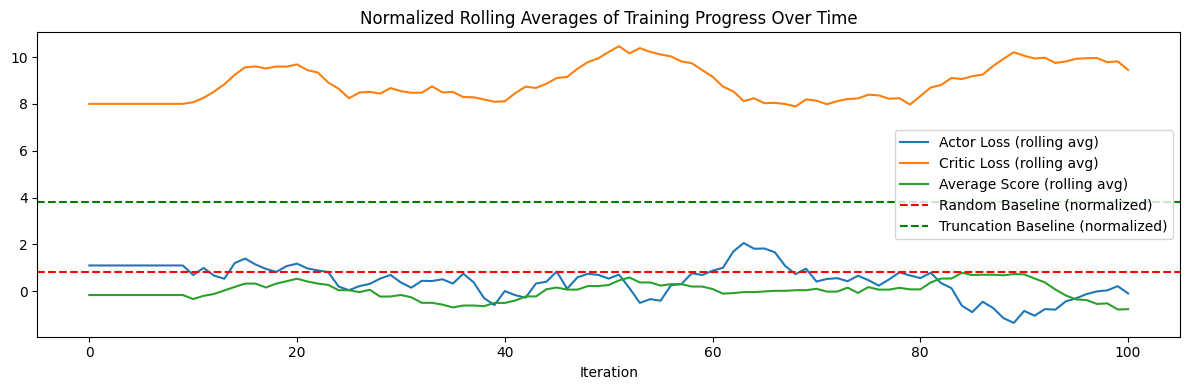

In [36]:
config = {
    'compute_baselines': False,
    'initial_population': initial_population,
    'genetic_map': genetic_map,
    'population_size': population_size,
    'marker_count': marker_count,
    'heritability': .99,
    'episodes': 10,
    'cycles': 2,
    'learning_rate': .001,
    'replicates': 1,
    'layer_size': 1024,
    'ploidy':2,
    'actor_lr':.00005,
    'critic_lr':.0000005, 
}

# WRITE TRAINING LOOP BELOW HERE
agent = BreederAgent(config)
# actor_optimizer = tf.keras.optimizers.Adam(learning_rate=.0005)
# critic_optimizer = tf.keras.optimizers.Adam(learning_rate=.00005)
# Define hyperparameters
num_iterations = 1000  # Number of training iterations
batch_size = 1
epochs = 2
# Lists to store metrics for visualization
actor_losses = []
critic_losses = []
average_scores = []
# Training loop
for iteration in range(num_iterations):
    # Train the PPO agent
    actor_loss, critic_loss, average_score = agent.train_ppo(
        epochs=epochs,
        batch_size=batch_size,
        gamma=0.95,
        lam=0.95,
        clip_ratio=0.2
    )
    
    # Log the training progress
    # print(f'Iteration: {iteration}, Actor Loss: {actor_loss}, Critic Loss: {critic_loss}, Average Score: {average_score}')
        # Store the training progress
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
    average_scores.append(average_score)

    # Plot the training progress every 50 iterations
    if iteration % 10 == 0:
        plot_training_progress(actor_losses, critic_losses, average_scores, iteration,agent)


True